## Tolkningsbarhet
- https://transformer-circuits.pub/2021/framework/index.html

### Autoencoders

_Autoencoders_ har en särskild roll för tolkningsbarhet. Dessa _självkodande_ algoritmer lär sig helt enkelt att kopiera in-noder till ut-noder. De lär sig alltså _identitetsfunktionen_. Matematiskt är detta väldigt intressant: ett typiskt exempel på en identitet är _identitetsmatrisen_ och som vi vet från linjäralgebran är alla inverterbara matriser reducerbara till just $I$. Så bara från det kan vi förvänta oss att systemet kan lära sig alla bijektiva linjära transformationer! Vi kan också ha färre antal ut- än in-noder och då tvinga nätverket att lära sig _latenta representationer_. 

Superposition (in neural networks)
> Superposition is when a model represents more than n features in an n-dimensional activation space. That is, features still correspond to directions, but the set of interpretable directions is larger than the number of dimensions.

(Definitionen enligt Neel Nanda, Google DeepMind)

Detta stämmer inte överens med den matematiska definitionen av superposition, utan motsvarar vad som i matematik kallas en _inbäddning_ (embedding). Uppenbara namnkonflikter! Komplexa tal är ett exempel på vad denna definitionen av superposition innefattar. I en matris av komplexa tal finns en extra 'latent' dimension, det komplexa talplanet. Kvarternioner har _tre_ latenta dimensioner.

$(c_1,c_2, ...)$ =  ($a_1+b_1i$ , $a_2+b_2i$, ... ) -> $\begin{bmatrix}a_1 & b_1 \\ a_2 & b_2 \\ : & :  \\\end{bmatrix}\begin{bmatrix}1 \\ i\end{bmatrix}$


Dessa nätverk lär sig hyperkomplexa representationer, vilket motsvarar någon "hyperform" i ännu högre dimensioner (inte nödvändigtvis ett hyperplan om nätverket innehåller icke-linjäritet). 

#### PCA med autoencoder

Detta exempel projicerar 3D ner till 2D och sedan tillbaka till 3D. Detta är linjära avbildingar, så vi behöver ingen aktiveringsfuktion.

In [ ]:
import torch
import torch.nn as nn

device = "cuda"

torch.manual_seed(42)
encoder = nn.Linear(3, 2)
decoder = nn.Linear(2, 3)
autoencoder = nn.Sequential(encoder, decoder).to(device)

Generera 3D data

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation

def generate_data(m, seed=42):
    X = np.zeros((m, 3))  # initialize 3D dataset
    rng = np.random.default_rng(seed)
    angles = (rng.random(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
    X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
    X += 0.28 * rng.standard_normal((m, 3))  # add more noise
    X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
    X += [0.2, 0, 0.2]  # shift a bit
    return torch.from_numpy(X.astype(np.float32))

In [3]:
from torch.utils.data import DataLoader, TensorDataset
import torchmetrics

def evaluate_tm(model, data_loader, metric):
    model.eval()
    metric.reset()
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            metric.update(y_pred, y_batch)
    return metric.compute()

def train(model, optimizer, loss_fn, metric, train_loader, valid_loader,
          n_epochs, patience=2, factor=0.5, epoch_callback=None):
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", patience=patience, factor=factor)
    history = {"train_losses": [], "train_metrics": [], "valid_metrics": []}
    for epoch in range(n_epochs):
        total_loss = 0.0
        metric.reset()
        model.train()
        if epoch_callback is not None:
            epoch_callback(model, epoch)
        for index, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()
            if isinstance(y_pred, tuple):
                y_pred = y_pred.output
            metric.update(y_pred, y_batch)
            train_metric = metric.compute().item()
            print(f"\rBatch {index + 1}/{len(train_loader)}", end="")
            print(f", loss={total_loss/(index+1):.4f}", end="")
            print(f", {train_metric=:.3f}", end="")
        history["train_losses"].append(total_loss / len(train_loader))
        history["train_metrics"].append(train_metric)
        val_metric = evaluate_tm(model, valid_loader, metric).item()
        history["valid_metrics"].append(val_metric)
        scheduler.step(val_metric)
        print(f"\rEpoch {epoch + 1}/{n_epochs},                      "
              f"train loss: {history['train_losses'][-1]:.4f}, "
              f"train metric: {history['train_metrics'][-1]:.3}, "
              f"valid metric: {history['valid_metrics'][-1]:.3}")
    return history

In [4]:
X_valid = generate_data(500, seed=43)
valid_set = TensorDataset(X_valid, X_valid)
valid_loader = DataLoader(valid_set, batch_size=32)

In [5]:
X_train  = generate_data(60)
train_set = TensorDataset(X_train, X_train)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

Nesterov adam optimerare, $\mathcal{l}_2$ metrik (kvadraterna på avståndet till _regresionslinjen_, jmf $\mathcal{l}_2$ reguljärisering då vi applicerar samma norm även på _parametrarna_.)

In [ ]:
optimizer = torch.optim.NAdam(autoencoder.parameters(), lr=.2)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
train(autoencoder, optimizer, mse, rmse, train_loader, valid_loader, n_epochs=20)

Epoch 1/20,                      train loss: 0.1712, train metric: 0.416, valid metric: 0.368
Epoch 2/20,                      train loss: 0.0849, train metric: 0.295, valid metric: 0.298
Epoch 3/20,                      train loss: 0.0623, train metric: 0.25, valid metric: 0.274
Epoch 4/20,                      train loss: 0.0520, train metric: 0.227, valid metric: 0.264
Epoch 5/20,                      train loss: 0.0426, train metric: 0.209, valid metric: 0.22
Epoch 6/20,                      train loss: 0.0354, train metric: 0.187, valid metric: 0.211
Epoch 7/20,                      train loss: 0.0310, train metric: 0.177, valid metric: 0.205
Epoch 8/20,                      train loss: 0.0288, train metric: 0.17, valid metric: 0.202
Epoch 9/20,                      train loss: 0.0289, train metric: 0.169, valid metric: 0.2
Epoch 10/20,                      train loss: 0.0279, train metric: 0.168, valid metric: 0.197
Epoch 11/20,                      train loss: 0.0279, train metr

{'train_losses': [0.17124208807945251,
  0.08489789441227913,
  0.06231253780424595,
  0.05202309601008892,
  0.04258358385413885,
  0.035413146018981934,
  0.03104352578520775,
  0.02876113075762987,
  0.028861156664788723,
  0.02790760062634945,
  0.027872352860867977,
  0.027960495091974735,
  0.027447820641100407,
  0.027265865355730057,
  0.026633037254214287,
  0.027208137325942516,
  0.026567522436380386,
  0.026878472417593002,
  0.026825712993741035,
  0.026606149040162563],
 'train_metrics': [0.4160463511943817,
  0.29462113976478577,
  0.24965551495552063,
  0.22746780514717102,
  0.20898833870887756,
  0.18698926270008087,
  0.17717386782169342,
  0.17012615501880646,
  0.16890287399291992,
  0.16789422929286957,
  0.16651128232479095,
  0.1658364236354828,
  0.16523149609565735,
  0.16452527046203613,
  0.16414926946163177,
  0.16368360817432404,
  0.16331510245800018,
  0.16317148506641388,
  0.16290754079818726,
  0.1629571169614792],
 'valid_metrics': [0.368461906909942

In [11]:
codings = encoder(X_train.to(device))

Intressant nog är _decodern_ vårt första exempel på en _generativ_ teknik. Den rekonstruerar alltså 3D data från 2D enligt mönstret den lärt sig. Inte så intressant i detta fall (det gäller ju bara precis den här PCA:n).

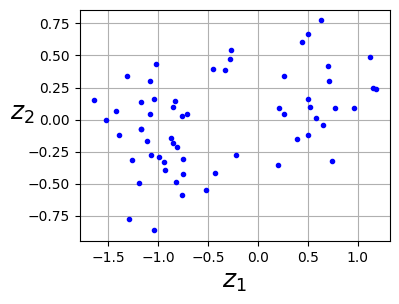

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,3))
codings_np = codings.cpu().detach().numpy()
plt.plot(codings_np[:,0], codings_np[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()



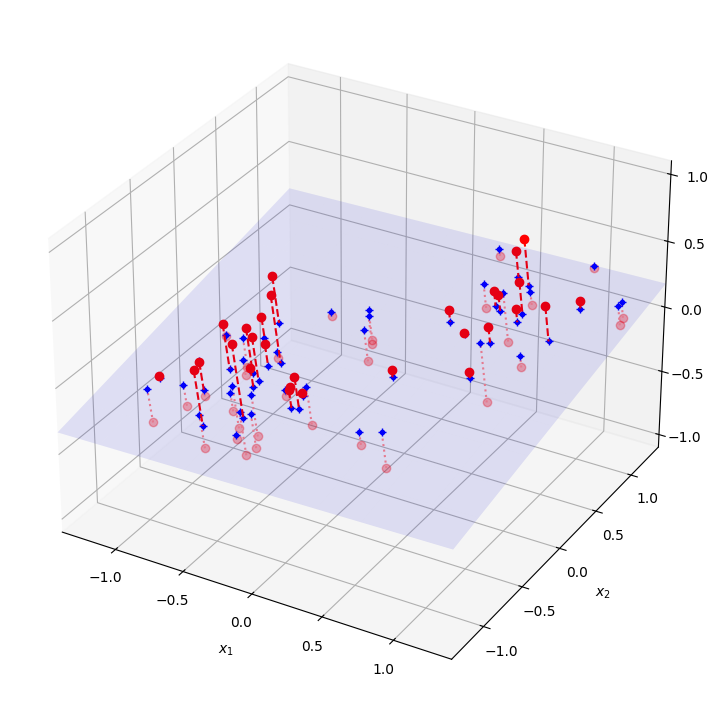

In [ ]:
# extra code – this cell generates Figure 7–2

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
X = X_train.numpy()
m =  len(X)
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])


plt.show()



En självkodare kan också vara _djup_ (stacked autoencoder). Då börjar rekonstrueringen och dess generativa kapacitet bli mer intressant.

In [16]:
stacked_encoder = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1*28*28, 128),
    nn.ReLU(),
    nn.Linear(128,32),
    nn.ReLU()
)

stacked_decoder = nn.Sequential(
    nn.Linear(32, 128),
    nn.ReLU(),
    nn.Linear(128, 1*28*28),
    nn.Sigmoid(),
    nn.Unflatten(dim=1, unflattened_size=(1,28,28))
)

stacked_ae = nn.Sequential(stacked_encoder, stacked_decoder).to(device)

Träna den på FashionMNIST bilderna:

In [ ]:
import torchvision
import torchvision.transforms.v2 as T

toTensor = T.Compose([T.ToImage(), T.ToDtype(torch.float32, scale=True)])

train_and_valid_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=True, download=True, transform=toTensor)
test_data = torchvision.datasets.FashionMNIST(
    root="datasets", train=False, download=True, transform=toTensor)

torch.manual_seed(42)
train_data, valid_data = torch.utils.data.random_split(
    train_and_valid_data, [55_000, 5_000])

In [ ]:
from torch.utils.data import Dataset

class AutoencoderDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        x, _ = self.base_dataset[idx]
        return x, x

train_loader = DataLoader(AutoencoderDataset(train_data), batch_size=32,
                          shuffle=True)
valid_loader = DataLoader(AutoencoderDataset(valid_data), batch_size=32)
test_loader = DataLoader(AutoencoderDataset(test_data), batch_size=32)

In [ ]:
optimizer = torch.optim.NAdam(stacked_ae.parameters(), lr=0.01)
mse = nn.MSELoss()
rmse = torchmetrics.MeanSquaredError(squared=False).to(device)
history = train(stacked_ae, optimizer, mse, rmse, train_loader, valid_loader,
                n_epochs=10)

Epoch 1/10,                      train loss: 0.0251, train metric: 0.159, valid metric: 0.146
Epoch 2/10,                      train loss: 0.0196, train metric: 0.14, valid metric: 0.145
Epoch 3/10,                      train loss: 0.0185, train metric: 0.136, valid metric: 0.135
Epoch 4/10,                      train loss: 0.0180, train metric: 0.134, valid metric: 0.132
Epoch 5/10,                      train loss: 0.0159, train metric: 0.126, valid metric: 0.126
Epoch 6/10,                      train loss: 0.0156, train metric: 0.125, valid metric: 0.127
Epoch 7/10,                      train loss: 0.0154, train metric: 0.124, valid metric: 0.125
Epoch 8/10,                      train loss: 0.0145, train metric: 0.12, valid metric: 0.122
Epoch 9/10,                      train loss: 0.0143, train metric: 0.12, valid metric: 0.121
Epoch 10/10,                      train loss: 0.0142, train metric: 0.119, valid metric: 0.121


Hur vet vi om det blev bra? Ja, vi kan inspektera bilderna i detta fall men det kan vara svårt att avgöra kvalitén på en självkodare utan mycket validerings- och testdata.

In [ ]:
def plot_image(image):
    plt.imshow(image.permute(1, 2, 0).cpu(), cmap="binary")
    plt.axis("off")

def plot_reconstructions(model, images, n_images=5):
    images = images[:n_images]
    with torch.no_grad():
        y_pred = model(images.to(device))
    if isinstance(y_pred, tuple):
        y_pred = y_pred.output
    fig = plt.figure(figsize=(len(images) * 1.5, 3))
    for idx in range(len(images)):
        plt.subplot(2, len(images), 1 + idx)
        plot_image(images[idx])
        plt.subplot(2, len(images), 1 + len(images) + idx)
        plot_image(y_pred[idx])

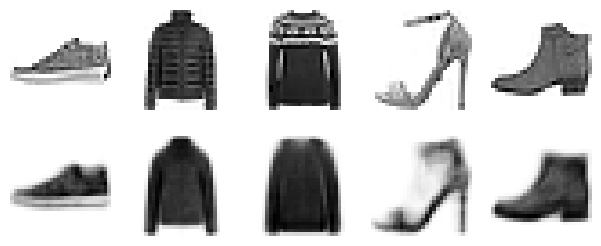

In [ ]:
X_valid = torch.stack([x for x, _ in valid_data])
plot_reconstructions(stacked_ae, X_valid)

plt.show()

Orginalbilderna överst, rekonstruktionerna nedan. Ok, men också väldigt _lossy_. Behöver mer träning, reguljärisering och kanske ändrade lager.

### Sparse Autoencoders (SAEs)

En SAE tenderar att aktivera separata noder i utlagret för klustrar av aktiveringar i indatan -- vilket är användbart för feature separering för tolkningsbarhet.

Genom att ändra optimeringsvillkoret till att föredra _glesa_ representationer får vi en Sparse Autoencoder. Ett sätt är att $\mathcal{l}_1$ reguljärisera mellan lagren i nätverket -- detta skulle leda till glesa representationer då mindre relevanta parametrar går mot noll. I praktiken erhålls mycket bättre resultat med _Kullback-Leibler_ divergens:
\begin{equation*}
D(p || q) = p \log \frac{p}{q} + (1-p) \log \frac{1-p}{1-q}
\end{equation*}



Se boken för implementation av denna loss-funktion, s 714 (det är dock bara formeln ovan gånger en hyperparameter + MSE).

### Steering

En ny teknik för att styra beteendet hos LLMer, som inte beror på prompt engineering eller fine-tuning är så-kallad _steering_. Detta är det allra senaste och resultaten från olika studier motsäger varandra gällande effektiviteten och till och med funktionen hos dessa tekniker. Vi använder SAEs (eller liknande tekniker) mellan lager i en LLM och läser ut feature-vektorn från resultatet. Ibland kan vi hitta väldigt tydliga koncept bland dessa, men lika ofta är lagrena och deras features svårtolkade och med djupa interaktionseffekter. I biologiska nätverk är aktiviteten hos en enskild nod mer eller mindre oberoende från aktiviteten bland flera noder-- dvs en biologisk neuron kan delta i _flera_ interaktioner samtidigt. Liknande strukturer uppstår i NN, även om de inte stöds av fysiska kopplingar, vilket kan antyda att fenomenet är djupare än vare sig matematisk överlagring/inbäddning eller de föreslagna motsvarande begrepp i tolkningsbarhetsläran. De skulle då vara _beräkningsmässigt_ förfördelade, snarare än genom något optimeringsvillkor eller evolutionärt tryck. Detta debatteras av fysiker, biologer och datavetare till ingen ända (än så länge).

Hursomhelst så är idéerna användbara för att förstå de _existerande_ artificiella neurala nätverken-- oavsett om begreppen är "naturliga" eller inte. 

Här använder vi det som en ingång till att förstå tolkningsbarhet hos LLMer snarare än en teknik för att ändra dess beteende.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import transformers
transformers.logging.set_verbosity_error()
import torch
import os 
#os.environ["PYTORCH_CUDA_ALLOC_CONF"]="expandable_segments:True"
device = "cuda"
dtype = torch.bfloat16

llm = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.1-8B-Instruct", dtype=dtype, device_map="cuda")
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
template = [{"role":"user", "content":"What are some sights to see in your lifetime?"}]
input_ids = tokenizer.apply_chat_template(template, tokenize=True, add_generation_prompt=True, return_tensors="pt", return_dict=True).to("cuda")
outputs = llm.generate(**input_ids, max_new_tokens=256, do_sample=False, repetition_penalty=1.1)

In [ ]:
print(tokenizer.decode(outputs[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

What are some sights to see in your lifetime?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

There are countless incredible sights to see around the world, and what's considered a "must-see" can vary depending on personal interests and preferences. Here are some of the most iconic and awe-inspiring destinations:

**Natural Wonders**

1. **Grand Canyon (USA)**: One of the most spectacular natural wonders in the United States.
2. **Aurora Borealis (Northern Lights) (Arctic/Norway)**: Witness the breathtaking display of colored lights dancing across the night sky.
3. **Great Barrier Reef (Australia)**: Explore the world's largest coral reef system, home to an incredible array of marine life.
4. **Victoria Falls (Zambia/Zimbabwe)**: Marvel at the sheer power and beauty of one of the world's largest waterfall

Ett väldigt typiskt svar från en LLM. 

Låt oss nu stimulera en specifik feature-vektor i den kommersiellt använda LLMen vi valt. Men hur hittar vi en sådan vektor? Jo, forskare och användare har kört SAEr på flera stora modeller och tolkat resultaten delivs manuellt och delvis maskinellt.

- https://neuronpedia.org/

Det finns flera paket på huggingface också.

In [ ]:
import json
import torch
with open("../Data/llama3.1-8b-it_15-resid-post-aa_23443.json", 'r') as fd:
    feature = json.load(fd)
v = torch.tensor(feature['vector'], dtype=dtype).to(device)
coefficient = 3.6
layer_idx = 15

def steering_hook(module, input, output):
    return output + coefficient*v

hook_handle=llm.model.layers[layer_idx].mlp.register_forward_hook(steering_hook)


Här har jag sökt och klickat omkring och hittat en rolig feature vektor i lager 15. Mittenlagren antas vara där de mest abstrakta representationerna finns-- de högra lagren aktiveras vid inmatning och de lägre vid utmatning, så där borde begrepp som har med själva texten finnas medans semantiken antas husera i lagren i mitten. Värt att nämna att detta inte längre följer de gamla idéerna som var inspirerade av hjärnbarken (där saker borde bli mer abstrakta ju längre ner i nätverket man kommer). 

In [ ]:
outputs = llm.generate(**input_ids, max_new_tokens=256, do_sample=False, repetition_penalty=1.1)
print(tokenizer.decode(outputs[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

What are some sights to see in your lifetime?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

There be many a pirate's life, and there be many a pirate's treasure! Here be some of the most famous and sought-after sights to see on the high seas... er, I mean, on land!

**Island Getaways**

1. **The Caribbean Islands**: Visit the island of Tortuga, where pirates like Captain Blackbeet and Calley the Cap'n would sail the seven seas.
2. **Pirate Island**, or **Tortuga Island**, Jamaica: This is one o' the last remaining pirate islands, with hidden coves and secret caves.
3. **Bermuda**: A pirate haven, known for its golden sands, crystal-clear waters, and hidden treasures.

**Treasure-filled Cities**

1. **Port Royal**, Jamaica: The infamous pirate city, where the Jolly Roger flew high and the sea dogs roamed

Ganska tydligt vad för koncept det här är, eller hur! Svårt att argumentera mot att detta är begreppet "pirat" från sagan. Det är ju tydligt inte en riktig pirat, de hänsynslösa våldsbrottslingar som mördar och stjäl från fraktskepp på havet, utan sagans pirat från litteratur, film och dataspel. Jag hittade denna vektor genom att söka efter "pirate" och "ahoy matey" på neuronpedia. Därefter letade jag upp den gemensamma feature som aktiverades starkast för båda.

Det är ibland väldigt snäva intervall av värden som stimulerar en feature. För lite eller för mycket kan ha allt från subtila effekter någon annan stans i nätverket till att hela nätverket bryter ihop i någon sorts blixtrande kortslutning som spottar ur sig tecken, delar av ord och namn eller samma ord eller fras om och om igen.

Det finns tekniker att hitta bra värden, det finns kurvor som visar aktiveringsfördelningar på neuronpedia tex-- men i praktiken har jag märkt att det enklaste är att bara testa sig fram!

In [ ]:
hook_handle.remove()
coefficient = 4
hook_handle=llm.model.layers[layer_idx].mlp.register_forward_hook(steering_hook)
outputs = llm.generate(**input_ids, max_new_tokens=256, do_sample=False, repetition_penalty=1.1)
print(tokenizer.decode(outputs[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

What are some sights to see in your lifetime?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

There be the most popular and mysterious sea creature of all time, the Krubulack.<|eot_id|>


Vår pirat är så mycket Pirat man kan vara vid det här laget.

In [ ]:
hook_handle.remove()
coefficient = 6.5
hook_handle=llm.model.layers[layer_idx].mlp.register_forward_hook(steering_hook)
outputs = llm.generate(**input_ids, max_new_tokens=256, do_sample=False, repetition_penalty=1.7)
print(tokenizer.decode(outputs[0]))

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

<|eot_id|><|start_header_id|>user<|end_header_id|>

What are some sights to see in your lifetime?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

Here that would him, the following is a list of what they might be known at them will know me and you can find any one or two.
1. The name may have been his once!
That was then! Here we'll give it:
So here I want so long ago where he were our time now let us make all three hands]
Keigh Keellagook Black Jack keekelake"
Black jack = black flag] So there follow these for example;
Strack=black flags!"
Jack stands as follows; A blood-blackflag`
A Blood-keegarlag'
Spells out "Blood' 'that's not yet an age."
The main part has got my captain from this makes more than many years when ye need just about every day... That gives away most parts with which could tell yer crew though!

Let fall by J., H._
`` ```
Doubert**
`_**

Här har vår stackars pirat tittat lite för djupt i romflaskan. Notera den väl tilltagna 'repetition_penalty', annars hade vi bara fått något enskilt ord eller tecken upprepat.